In [1]:
import numpy
%matplotlib nbagg
from matplotlib import pyplot
from tqdm import tnrange

In [2]:
from soapy import atmosphere, WFS, confParse
import aotools

In [3]:
SOAPY_CONF = "conf/wfs/shpixelvariance.yaml"

False
2560
8
82
pupilSize:64
simSize:66
4.0
[0]


<IPython.core.display.Javascript object>


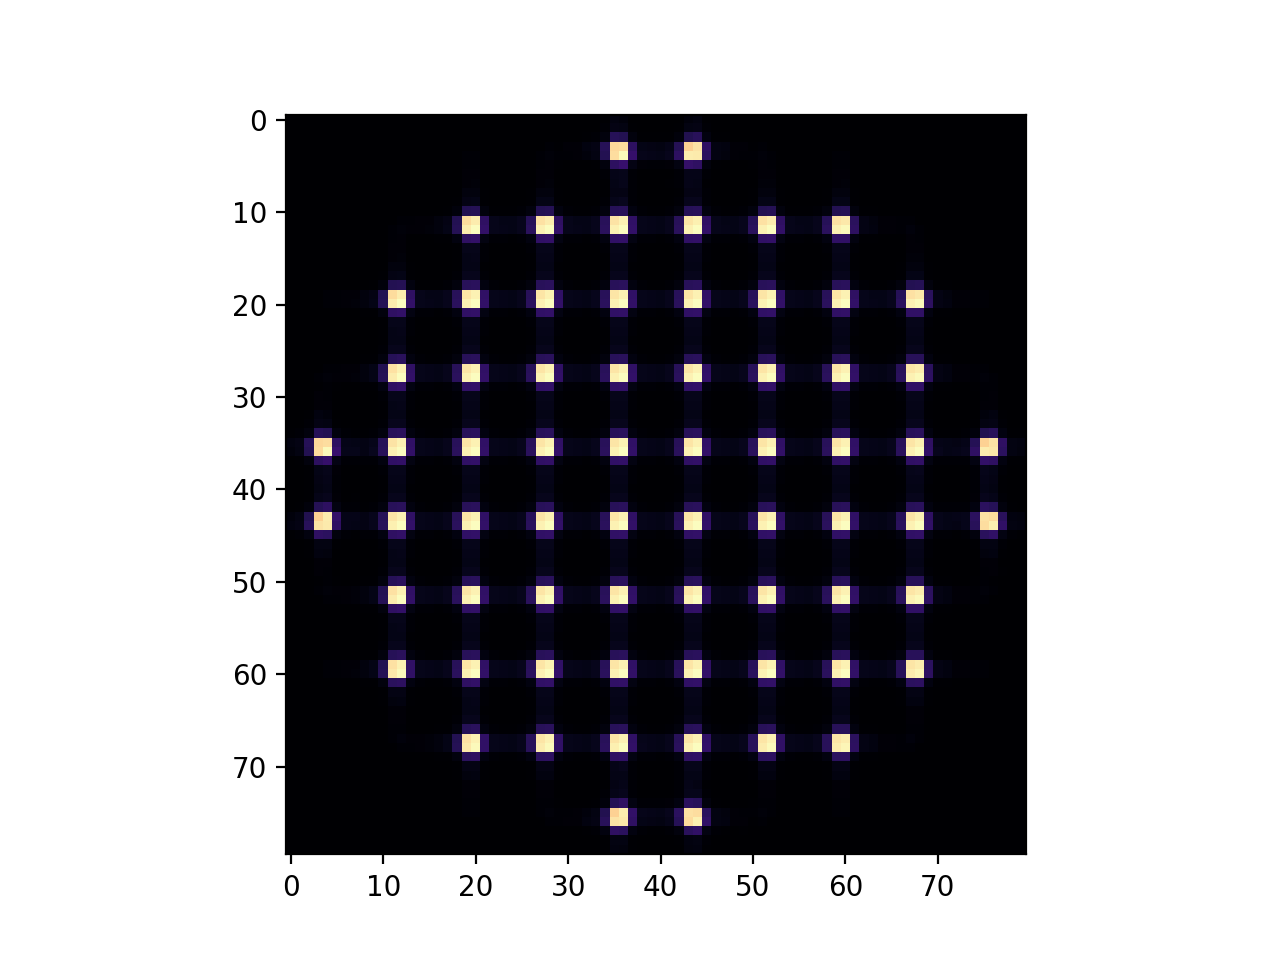

In [11]:
# Initialise the WFS
config = confParse.loadSoapyConfig(SOAPY_CONF)

config.sim.pupilSize = 64

config.tel.telDiam=1.

config.wfss[0].wavelength = 500e-9
config.wfss[0].subapFOV = 4.
config.wfss[0].subapThreshold = 1.
config.wfss[0].pxlsPerSubap = 8 

config.atmos.scrnNo = 1
config.atmos.wholeScrnSize = 64 * 40
config.atmos.windDirs[0] = 0
config.atmos.windSpeeds[0] = 50
config.atmos.infinite = False
config.atmos.L0 = numpy.array([100])
config.atmos.randomScrns = False


config.calcParams()

mask = aotools.circle(config.sim.pupilSize/2., config.sim.simSize)

wfs = WFS.ShackHartmann(config, 0, mask)

print(config.atmos.subHarmonics)
print(config.atmos.wholeScrnSize)
print(wfs.subapFOVSpacing)
print(wfs.scaledEFieldSize)
print("pupilSize:{}".format(config.sim.pupilSize))
print("simSize:{}".format(config.sim.simSize))
print(config.wfss[0].subapFOV)
print(config.atmos.scrnHeights)
pyplot.figure()
pyplot.imshow(wfs.wfsDetectorPlane)


In [12]:
# Make a set of phase screens to test
N_ITERS = 1000
N_SCRNS = 4

NR0 = 5
R0s = numpy.linspace(0.05, 0.25, NR0)

In [13]:
# Conversion from slopes into radians
wfsPxlScale_asec = float(config.wfss[0].subapFOV)/config.wfss[0].pxlsPerSubap
wfsPxlScale_deg = wfsPxlScale_asec/3600.
wfsPxlScale_rad = wfsPxlScale_deg * (numpy.pi/180.)
print(wfsPxlScale_rad)

2.42406840554768e-06


In [14]:
slopes = numpy.zeros((NR0, N_SCRNS*N_ITERS, wfs.activeSubaps))
# fig = pyplot.figure()
for ir0 in tnrange(NR0):
    r0 = R0s[ir0]
    print('Test R0: {}'.format(r0))
    config.atmos.r0 = r0
    for iscrn in tnrange(N_SCRNS):
        atmos = atmosphere.atmos(config)
        print('Made screen - starting run')
        for i in tnrange(N_ITERS):
            scrns = atmos.moveScrns()
            slopes[ir0, iscrn*N_ITERS + i] = wfs.frame(scrns)[:wfs.activeSubaps]
#             pyplot.cla()
#             pyplot.imshow(scrns[0])
#             fig.canvas.draw()

Test R0: 0.05


Made screen - starting run


Made screen - starting run


Made screen - starting run


Made screen - starting run


Test R0: 0.1


Made screen - starting run


Made screen - starting run


Made screen - starting run


Made screen - starting run


Test R0: 0.15000000000000002


Made screen - starting run


Made screen - starting run


Made screen - starting run


Made screen - starting run


Test R0: 0.2


Made screen - starting run


Made screen - starting run


Made screen - starting run


Made screen - starting run


Test R0: 0.25


Made screen - starting run


Made screen - starting run


Made screen - starting run


Made screen - starting run


In [15]:
# Convert slopes to rad
slopes_rad = slopes*wfsPxlScale_rad
# Measure r0 using slope variance
wvl = config.wfss[0].wavelength
# wvl = 600e-9
print("Wavelength (m): {}".format(wvl))
d = wfs.subapDiam
print("Subap Diameter (m): {}".format(d))
measuredR0 = numpy.zeros(NR0)
for i in range(NR0):
    sVar = slopes_rad[i].var(0).mean()
    measuredR0[i] = ((0.162*(wvl**2) * d**(-1./3)) / sVar)**(3./5)

Wavelength (m): 5e-07
Subap Diameter (m): 0.1


(5, 4000, 68)


<IPython.core.display.Javascript object>


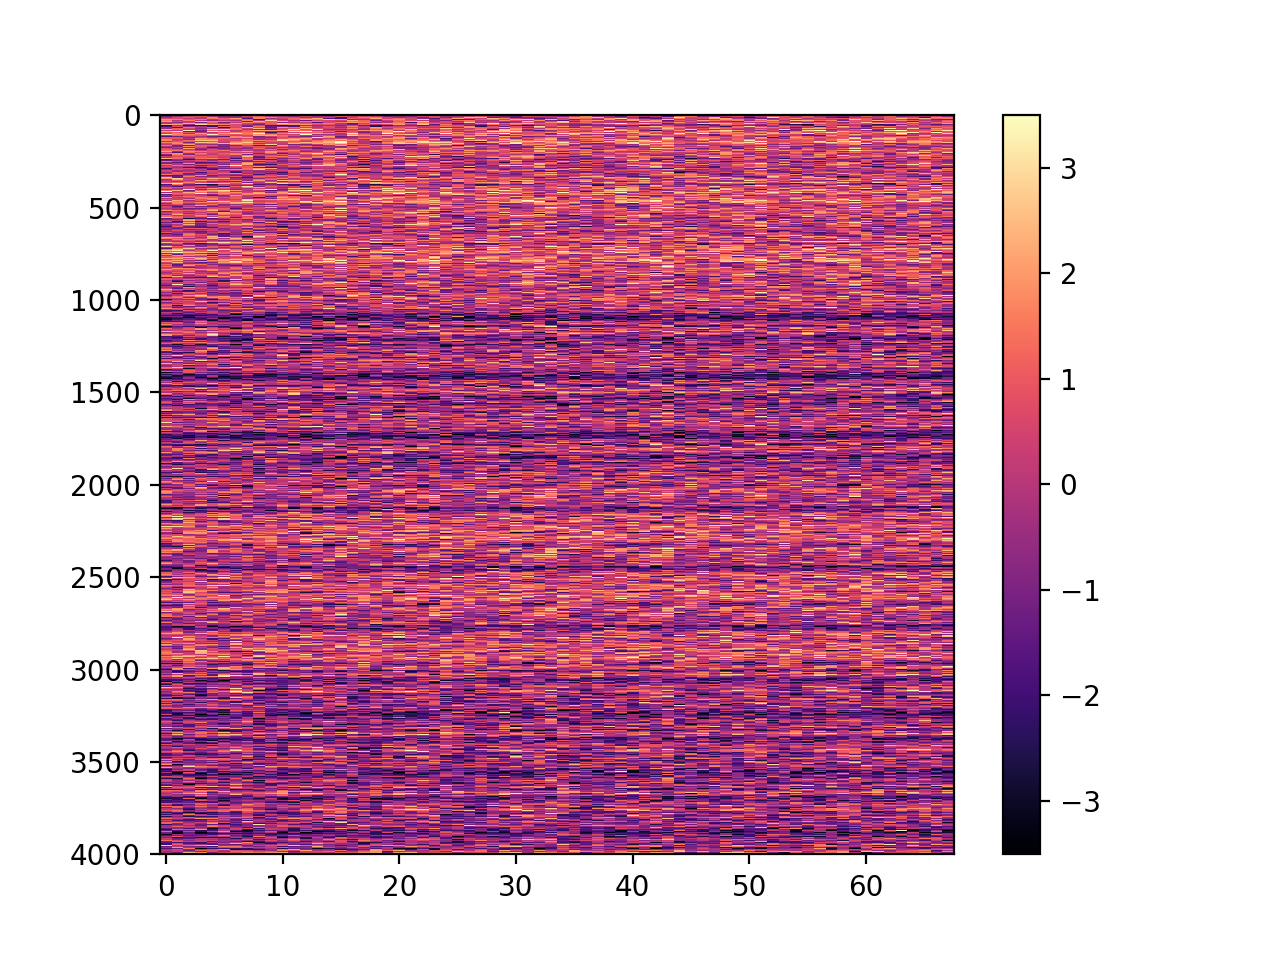

In [16]:
print(slopes.shape)
pyplot.figure()
pyplot.imshow(slopes[0], aspect="auto")
pyplot.colorbar()

<IPython.core.display.Javascript object>


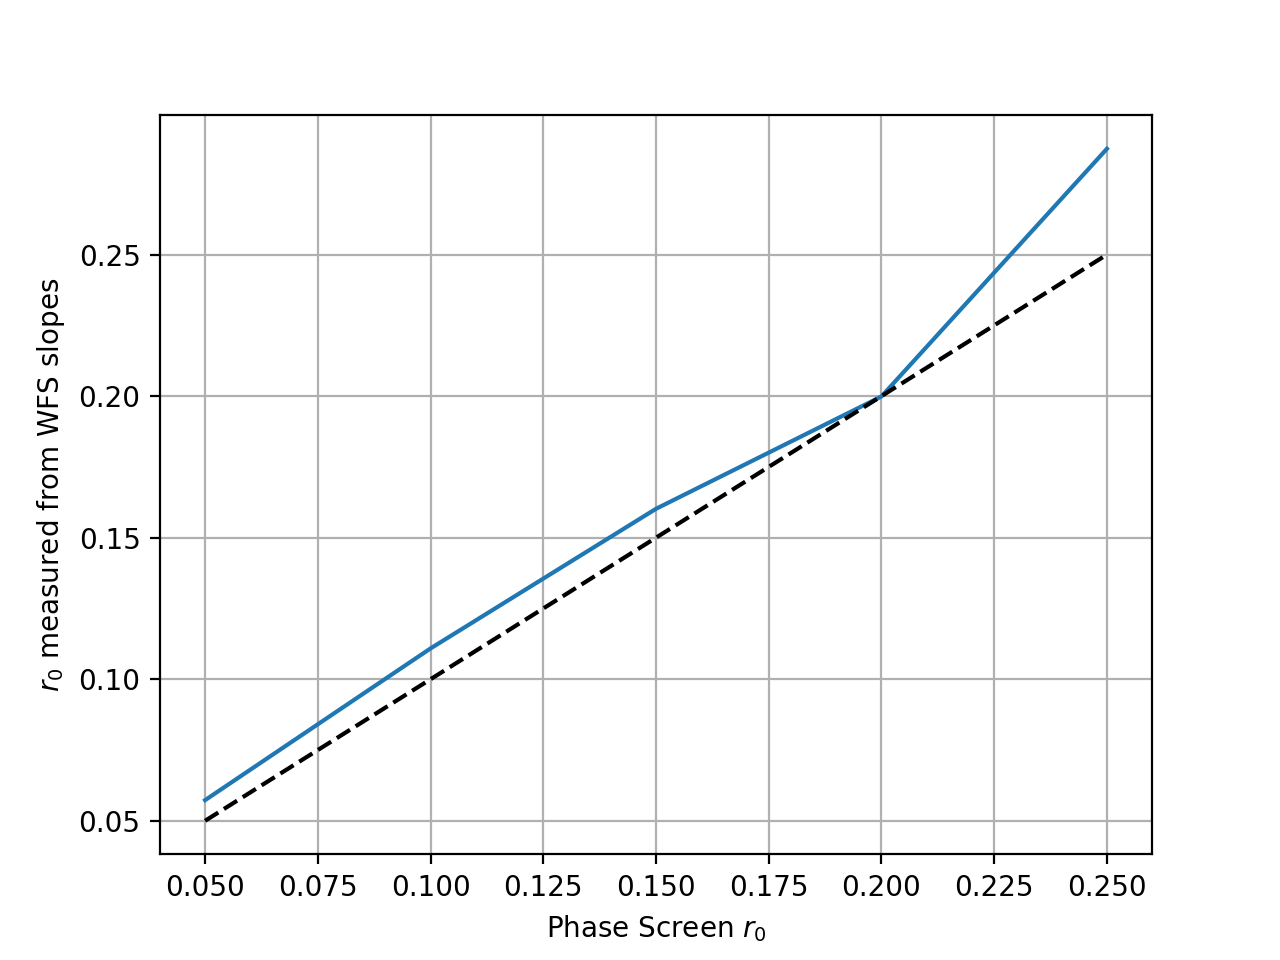

[ 0.05729865  0.11088531  0.16020332  0.19988375  0.28736414]


In [17]:
pyplot.figure()
pyplot.plot(R0s, measuredR0)
pyplot.plot(R0s, R0s, color="k", linestyle="--")
pyplot.grid()
pyplot.xlabel("Phase Screen $r_0$")
pyplot.ylabel("$r_0$ measured from WFS slopes")
print(measuredR0)